# Assignment: forward kinematics of a Thymio
The provided dataset represents the motion from the two wheels of a thymio, as measured through a pretty inaccurate method based on the observed voltages of the two motors (i.e. not a wheel encoder).

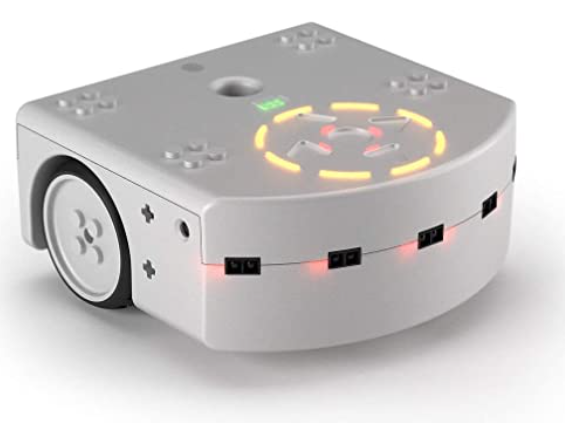

Each 0.1s, you get a reading that represents the total amount of rotation of the left and right wheels, since an arbitrary starting point in the past; the value corresponds to the total displacement, in meters, at the edge of each wheel (this already takes into account the wheel radius).

The distance between the wheels is $2l = 9.35$ cm.

## Data import

In [1]:
# importo i dati da data e li metto in una lista chiamata df



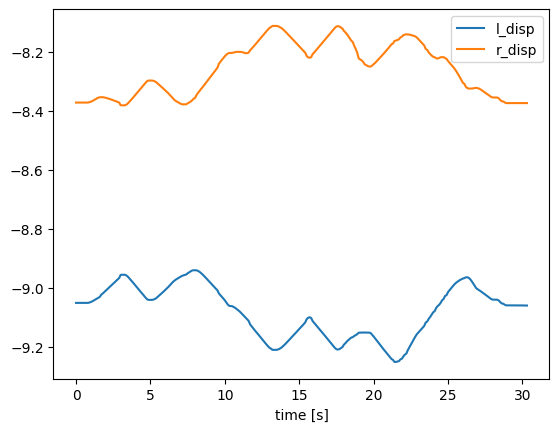

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("data.csv")
fig,ax = plt.subplots()
ax.plot(df["t"], df["l_disp"], label="l_disp")
ax.plot(df["t"], df["r_disp"], label="r_disp")
ax.set(xlabel = "time [s]")
ax.legend();

Observe that:
- When both lines move up, both wheels are moving forwards and the robot is advancing
- When both lines are horizontal, such as in the end, the robot is not moving
- The absolute values of each line do not matter, just their rates of change (that correspond to the tangential velocity of the wheels).

Let's now compute the tangential velocities of the two wheels, in m/s, and move to numpy arrays, that you might be more familiar with.

In [3]:
df[["l_vel","r_vel"]] = df[["l_disp","r_disp"]].diff(axis=0).fillna(0) / 0.1
l_vel, r_vel = df[["l_vel","r_vel"]].values.T
t = df["t"].values

You can now work with 1d numpy arrays `l_vel` (m/s), `r_vel` (m/s), `t` (s)

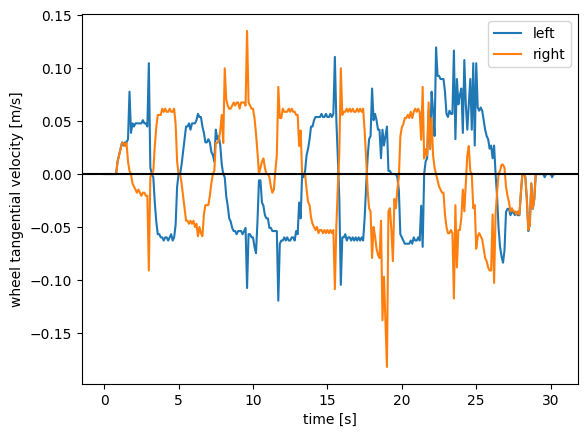

In [4]:
# Visualize to make sure the data is sane
fig,ax = plt.subplots()
ax.plot(t, l_vel, label="left")
ax.plot(t, r_vel, label="right")
ax.axhline(y=0, color="k")
ax.legend()
ax.set(xlabel="time [s]", ylabel="wheel tangential velocity [m/s]");

## Assignments

### 1: Compute and visualize the trajectory of the robot
This will require to implement the robot kinematics.
You can visualize the trajectory of the robot reference point as a line (note: you won't see the orientation of the robot!).

As a sanity check: the reference point of the robot moves within a small area (approximately $12 \times 10$ centimeters); the robot often turns in place, don't expect a long smooth trajectory.

CODICE SBAGLIATO: 
```python

#l = metà della distanza tra le ruote
l = 9.35/2
dt = 0.1   # intervallo di tempo in secondi tra due campioni

# Numero di campioni
n = len(df)

# Inizializza gli array per x, y, e l'orientamento theta
x = np.zeros(n)
y = np.zeros(n)
theta = np.zeros(n)

# Condizioni iniziali: il robot parte da (0, 0) con orientamento 0 rad
x[0] = 0.0
y[0] = 0.0
theta[0] = 0.0

# Integrazione per ogni passo temporale usando il metodo di Eulero
for i in range(1, n):
    # Estrai le velocità per il k-esimo istante
    vl = df["l_disp"].iloc[i]    # velocità della ruota sinistra
    vr = df["r_disp"].iloc[i]    # velocità della ruota destra
    
    # Calcola la velocità lineare e quella angolare
    v = (vr + vl) / 2.0          # velocità lineare del robot
    omega = (vr - vl) / (2 * l)   # velocità angolare del robot
    
    # Aggiorna l'orientamento (θ)
    theta[i] = theta[i-1] + omega * dt
    
    # Aggiorna le posizioni x e y
    # Nota: usiamo theta[i-1] per calcolare l'incremento di posizione
    x[i] = x[i-1] + v * np.cos(theta[i-1]) * dt
    y[i] = y[i-1] + v * np.sin(theta[i-1]) * dt

# Visualizza il percorso del robot
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Percorso del Robot")
plt.grid(True)
plt.axis('equal')  # assi con lo stesso scaling
plt.show()
```

Questo dovrebbe essere quasi corretto ma non devo usare 
 Aggiorna le posizioni x e y
 Nota: usiamo theta[i-1] per calcolare l'incremento di posizione
    x[i] = x[i-1] + v * np.cos(theta[i-1]) * dt
    y[i] = y[i-1] + v * np.sin(theta[i-1]) * dt

    invece lamatrice ditrasformazione utilizzata dal prof con questa funzione: 

In [5]:
def EXAMPLE_ddtr(vl, vr, l, dt):
    """ returns the pose transform for a motion with duration dt of a differential
    drive robot with wheel speeds vl and vr and wheelbase l """

    if(np.isclose(vl, vr)):  # we are moving straight, R is at the infinity and we handle this case separately   VEDO SE LA VELOCITA' DEI DUE MOTORI E' UGUALE
        return mktr((vr + vl)/2*dt, 0)  # note we translate along x ()          QUANTO IL MIO ROBOT SI SPOSTA LUNGO GLI ASSI X E Y

    omega = (vr - vl) / (2 * l)  # angular speed of the robot frame         ANGOLARE DEL ROBOT FORMULA DA SLIDE  28
    R = l * (vr + vl) / (vr - vl) # FORMULA DA SLIDE 28 SAREBBE IL RAGGIO DI CURVATURA

    # Make sure you understand this!
    return mktr(0, R) @ mkrot(omega * dt) @ mktr(0, -R)

tale funzione ritorna questa matrice:

<br>


![image-2.png](./MATRICE_DI_RITORNO_DDRT.png)
<br>

che spigato e:

<br>

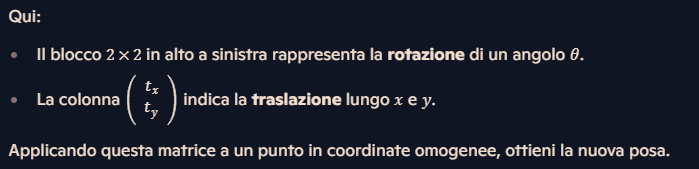
<br>

<function matplotlib.pyplot.show(close=None, block=None)>

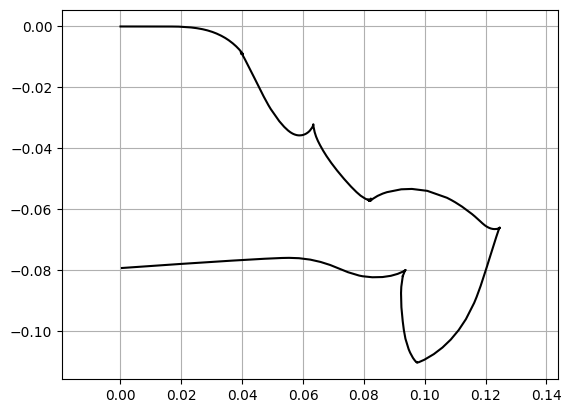

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Funzione: matrice di traslazione (in mm)
def mktr(tx, ty):
    """
    Crea una matrice di traslazione omogenea 3x3 che sposta di (tx, ty) [in m].
    
           [ 1   0   tx ]
       T = [ 0   1   ty ]
           [ 0   0    1 ]
    """
    return np.array([[1, 0, tx],
                     [0, 1, ty],
                     [0, 0, 1]])

# Funzione: matrice di rotazione
def mkrot(theta):
    """
    Crea una matrice di rotazione omogenea 3x3 per una rotazione di theta radianti.
    
             [ cos(theta)   -sin(theta)    0 ]
       R =   [ sin(theta)    cos(theta)     0 ]
             [     0             0          1 ]
    """
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta),  np.cos(theta), 0],
                     [0, 0, 1]])

# Funzione ddtr: calcola la trasformazione della posa per un intervallo dt
def ddtr(vl, vr, l, dt):
    """
    Restituisce la matrice di trasformazione (3x3) della posa per un intervallo dt
    di un robot a trazione differenziale.
    
      Parametri:
         - vl: velocità della ruota sinistra (in m/s)
         - vr: velocità della ruota destra (in m/s)
         - l: parametro (tipicamente metà della distanza tra le ruote) in m
         - dt: intervallo di tempo in secondi
    """
    if np.isclose(vl, vr):
        # Caso rettilineo: il robot si sposta in avanti lungo l'asse x del suo riferimento
        return mktr((vl + vr) / 2 * dt, 0)
    
    # Caso curvo:
    omega = (vr - vl) / (2 * l)          # Velocità angolare in rad/s
    R = l * (vl + vr) / (vr - vl)          # Raggio di curvatura (in mm)
    # Composizione della trasformazione:
    # 1. Traslazione per centrare il sistema sul centro di rotazione: mktr(0, -R)
    # 2. Rotazione di omega*dt: mkrot(omega*dt)
    # 3. Ritraslazione: mktr(0, R)
    return mktr(0, R) @ mkrot(omega * dt) @ mktr(0, -R)

#############################################
# CODICE DI INTEGRAZIONE DELLA POSE USANDO ddtr
#############################################




current_pose = np.eye(3)
robot_ref_point_at_start = np.array([0, 0, 1])
robot_direction_at_start = np.array([0, 0, 1])

positions = []
directions = []

l = 9.35 / 2 / 100
dt = 0.1

for index, row in df.iterrows():
    vl = row["l_vel"]
    vr = row["r_vel"]
    pose = ddtr(vl, vr, l, dt)
    current_pose = current_pose @ pose
    position = current_pose @ robot_ref_point_at_start #passo da base robot a base mondo
    positions.append(position[0:2])
    direction = current_pose @ robot_direction_at_start #passo da base robot a base mondo
    directions.append(direction[0:2])
    
positions = np.array(positions)
directions = np.array(directions)
plt.plot(positions[:,0], positions[:,1], color="black")
plt.gca().axis("equal")
#metto una griglia
plt.grid()
plt.show






<function matplotlib.pyplot.show(close=None, block=None)>

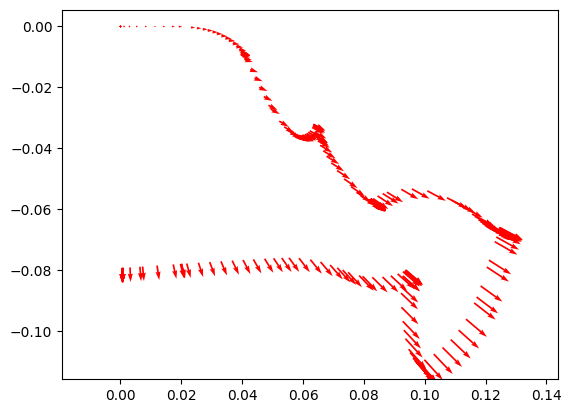

In [7]:
#stampo un nuovo grafico sotto il precedente per vedere la direzione del robot
plt.quiver(positions[:,0], positions[:,1], directions[:,0], directions[:,1], color="red")
plt.gca().axis("equal")

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

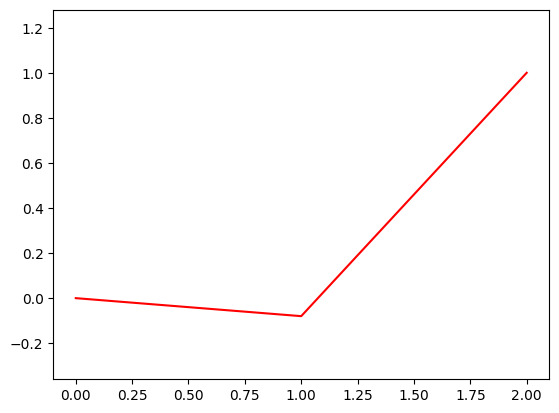

In [8]:
plt.plot(direction, color="red")
plt.gca().axis("equal")

plt.show

### 2: visualize the trajectory as an animation
Draw the robot and its orientation as a dot with a short line to indicate the direction it is facing.

To visualize the animation using matplotlib, have a look [here](https://matplotlib.org/stable/gallery/animation/simple_anim.html).

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

df = pd.read_csv("data.csv")

# Assicurati che l'animazione funzioni in Jupyter Notebook
%matplotlib notebook

fig, ax = plt.subplots()
ax.set_xlim(np.min(positions[:, 0]) - 0.1, np.max(positions[:, 0]) + 0.1)
ax.set_ylim(np.min(positions[:, 1]) - 0.1, np.max(positions[:, 1]) + 0.1)
ax.set_aspect('equal')
ax.grid()

# Punto per il robot e linea per la direzione
robot_dot, = ax.plot([], [], 'ro')  # Punto rosso
robot_dir, = ax.plot([], [], 'r-')  # Linea rossa per la direzione

def init():
    robot_dot.set_data([], [])
    robot_dir.set_data([], [])
    return robot_dot, robot_dir

def update(frame):
    x = positions[frame, 0]
    y = positions[frame, 1]
    
    dx = directions[frame, 0] * 0.1
    dy = directions[frame, 1] * 0.1

    robot_dot.set_data(x, y)
    robot_dir.set_data([x, x + dx], [y, y + dy])
    return robot_dot, robot_dir

ani = animation.FuncAnimation(fig, update, frames=len(positions), init_func=init, blit=True, interval=50)
#HTML(ani.to_jshtml())  # Mostra l'animazione nel notebook
plt.plot(positions[:, 0], positions[:, 1], 'bo-')  # Traiettoria del robot
plt.quiver(positions[:, 0], positions[:, 1], directions[:, 0], directions[:, 1], color='r')  # Vettori direzione
plt.axis("equal")
plt.grid()
plt.show()

plt.show()

print(df)
print("done")



<IPython.core.display.Javascript object>

        t    l_disp    r_disp
0     0.0 -9.050185 -8.371172
1     0.1 -9.050185 -8.371172
2     0.2 -9.050185 -8.371172
3     0.3 -9.050185 -8.371172
4     0.4 -9.050185 -8.371172
..    ...       ...       ...
299  29.9 -9.058860 -8.372935
300  30.0 -9.058860 -8.372935
301  30.1 -9.059159 -8.372935
302  30.2 -9.059159 -8.372935
303  30.3 -9.059159 -8.372935

[304 rows x 3 columns]
done


c:\Users\Alessio\Desktop\Dati\Usi_Robotics\usi_robotics\Lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [ ]:
#############################################
#REFERENCE CODE FOR ANIMATION:
#############################################
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

%matplotlib notebook

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, save_count=50)

HTML(ani.to_jshtml())  # Mostra l'animazione nel notebook
# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

<IPython.core.display.Javascript object>

c:\Users\Alessio\Desktop\Dati\Usi_Robotics\usi_robotics\Lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

### 3: account for uncertainty
Also estimate the accumulating uncertainty of the robot pose (with respect to its initial pose).

As a cheap way to do so, implement a Monte Carlo approach.  Compute 100 replicas of the trajectory; in each, you can corrupt the displacement (or velocity) measured at each timestep with a multiplicative gaussian i.i.d noise $k \sim \mathcal{N}(\mu, \sigma^2)$ with $\mu = 1$ and $\sigma = 0.1$.